# Demand for Electric Bicycles 
This project showcases a similar project I've worked on at my job. I’d like to share my thought process and explain how I approached the problem.

## Objective
Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric bicycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric bicycles in the Indian market.

The company wants to know:
- Which variables are significant in predicting the demand for shared electric bicycles in the Indian market?
- How well do those variables describe the electric bicycle demand.

## Data Description
The file bike_sharing.csv contains the usage data aggregated by the hour with the following columns:
- datetime - beginning of an hour for which the data are aggregated;
- season
    - 1: spring,
    - 2: summer,
    - 3: fall,
    - 4: winter;
- holiday - whether a day is a holiday or not
- workingday - if a day is neither weekend nor holiday is 1, otherwise is 0.
- weather
    - 1: clear, few clouds, scattered clouds
    - 2: mist + cloudy, mist + scattered clouds, mist + few clouds, mist
    - 3: light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
    - 4: heavy rain + ice pallets + thunderstorm + mist, snow + fog
- temp - air temperature in degrees Celsius
- atemp - feeling temperature in degrees Celsius
- humidity - air humidity in percent
- windspeed - wind speed in km/h
- casual - number of bikes rented by casual users
- registered - number of bikes rented by registered users
- count - total number of rented bikes including both casual and registered users

## EDA

Let import and observe the dataset. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('datasets/bike_sharing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Notice casual, registered, and count fields mean vs std. This can implicate high variability in the bike rental with potential outliers in the data set. 

Adding parts of the day as a feature.

In [4]:
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

ser_obj    = df['hour']
conditions = [ser_obj.between(5, 10), ser_obj.between(11,15), ser_obj.between(16,20), (ser_obj.between(21,23) | ser_obj.between(0,4))]

# 1 = morning rush, 2 = mid day/afternoon, 3 = afternoon rush, 4 = late night/early morning
values = [1,2,3,4]
df['day_part'] = np.select(conditions, values)

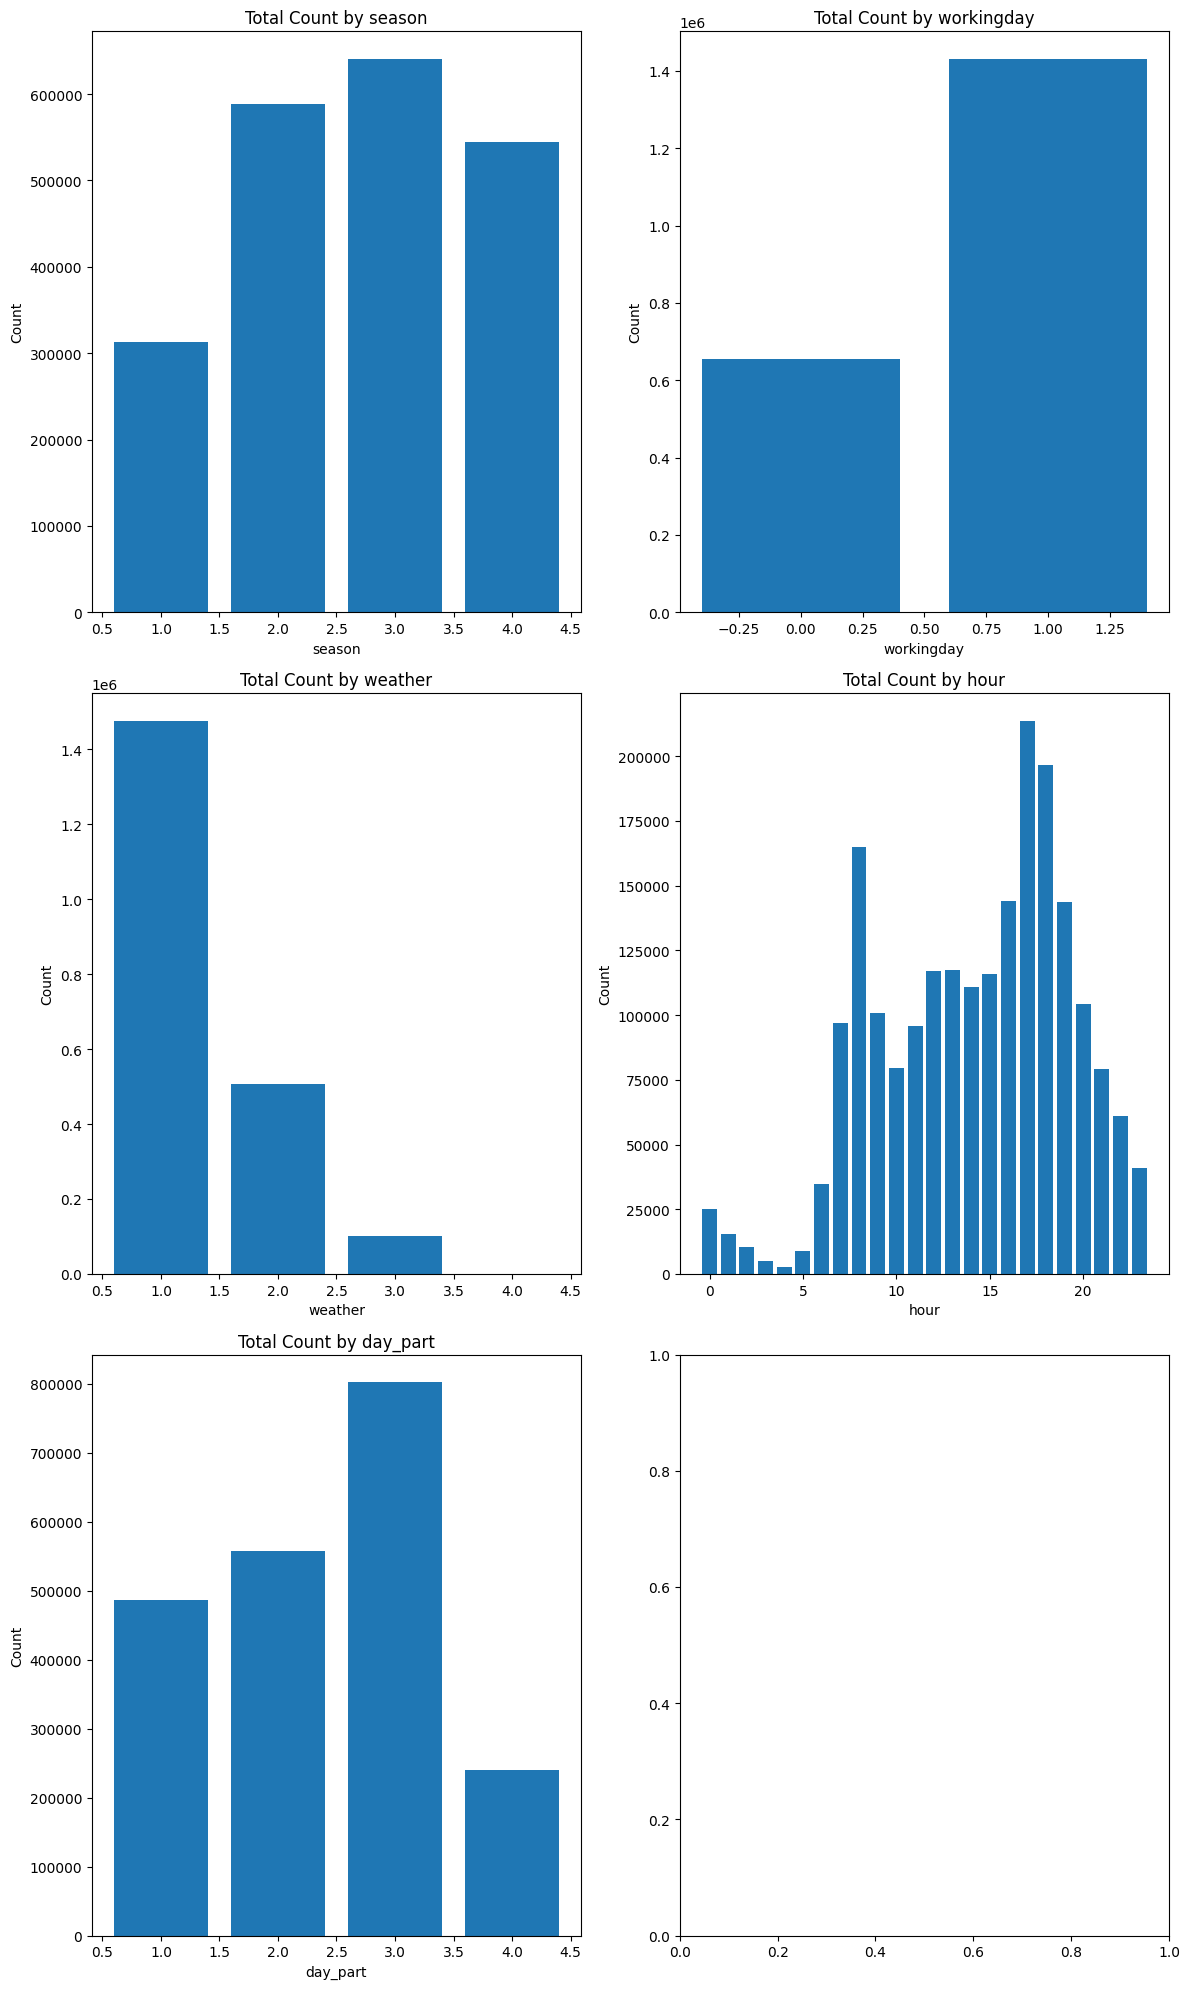

In [5]:
from math import ceil
cols = ['season', 'workingday', 'weather', 'hour', 'day_part']
rows = ceil(len(cols)/2)
fig, axes = plt.subplots(rows, 2, figsize=(12,4*len(cols)))
axes = axes.flatten()

for i, col in enumerate(cols):
    tmp = df.groupby(col)['count'].sum().reset_index()
    axes[i].bar(tmp[col], tmp['count'])
    axes[i].set_title(f'Total Count by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

Overall, the rental count distributions align logically with the attributes. Rentals tend to increase on clear, dry days and are generally higher during working days compared to non-working days. Usage also rises in the morning hours, peaks during the afternoon rush as people finish work, and gradually tapers off into the late evening and early morning.

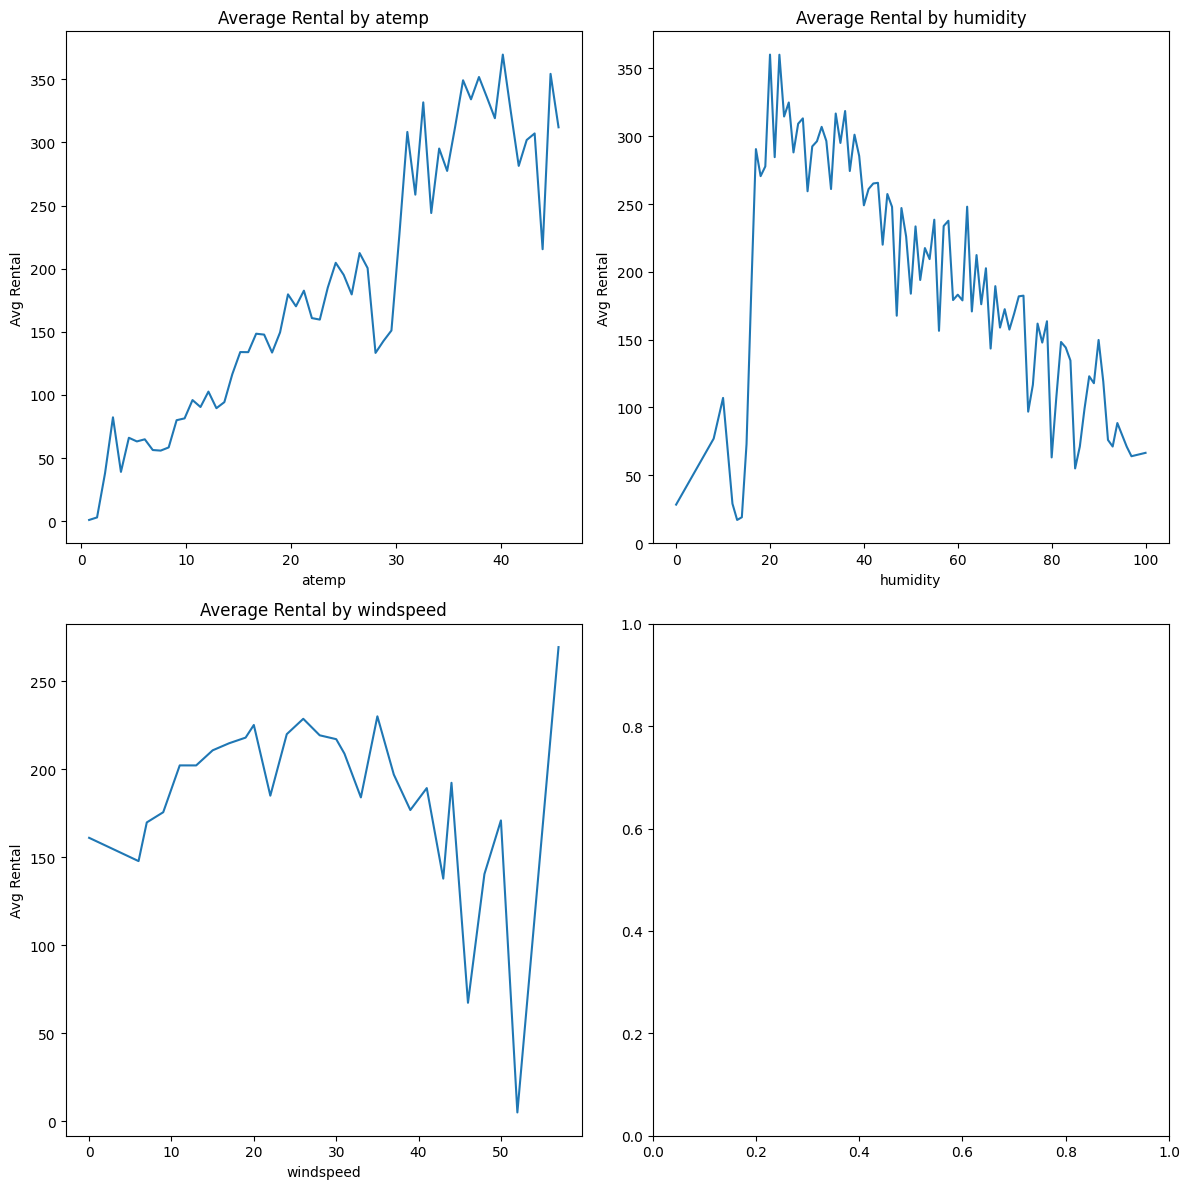

In [6]:
cols = ['atemp', 'humidity', 'windspeed']
rows = ceil(len(cols)/2)
fig, axes = plt.subplots(rows, 2, figsize=(12,4*len(cols)))
axes = axes.flatten()

for i, col in enumerate(cols):
    tmp = df.groupby(col)['count'].mean().rename('avg_rental').reset_index()
    axes[i].plot(tmp[col],tmp['avg_rental'])
    axes[i].set_title(f'Average Rental by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Avg Rental')

plt.tight_layout()
plt.show()

Similar patterns are observed here as well: rental activity increases with higher temperatures but tends to decline in high humidity, likely due to reduced comfort levels for riders.

Let create a correlation matrix for potential predictive indicators.

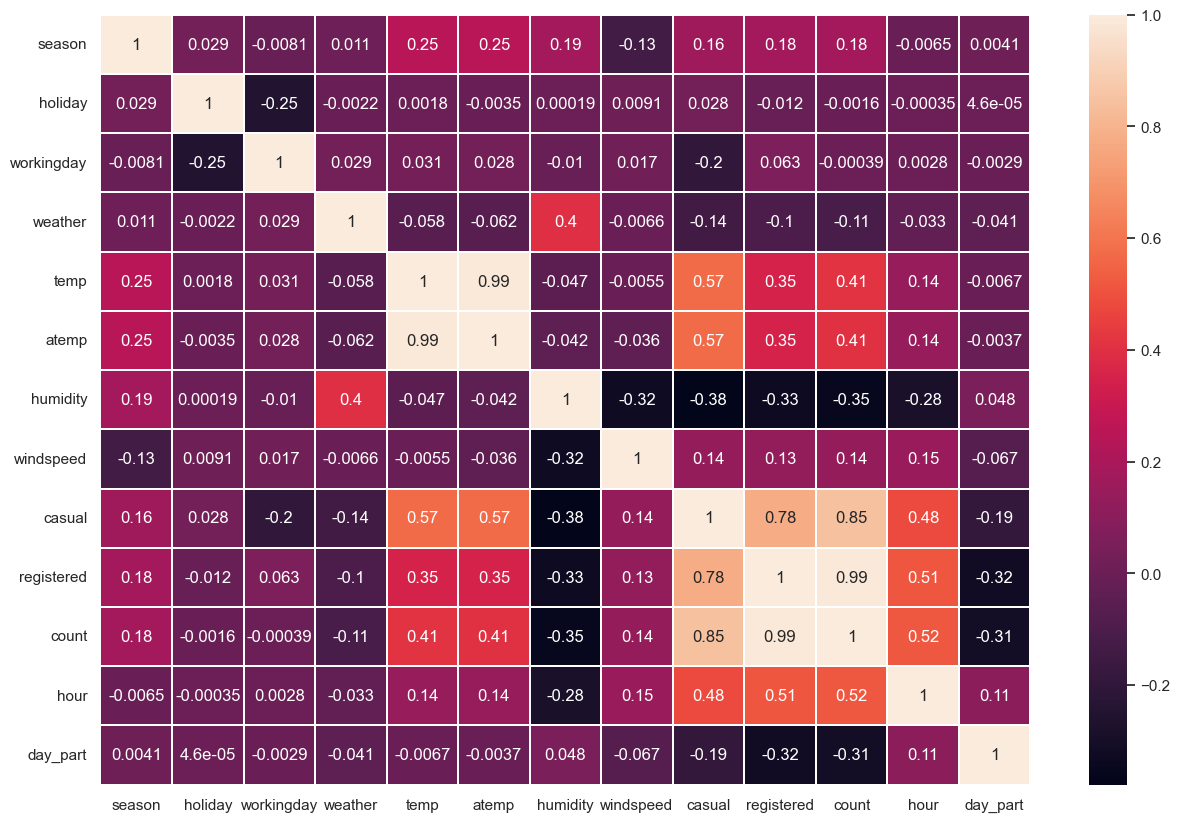

In [7]:
# correlation test to understand variables relationship to bike rental
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=df[df.columns[1:]].corr(method='spearman'),annot=True, linewidth=0.1)
plt.show()


Hour, apparent temperature (atemp), actual temperature (temp), and humidity show a moderate positive correlation with rental count, making them strong candidates for predictive features. However, temp and atemp appear to be multicollinear, as do casual and registered counts relative to total count. These variables should be excluded during modeling to prevent redundancy and ensure model stability.

# Multiple Linear Regression Test

In [8]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

cleaned_df = df.drop(columns=['temp', 'casual', 'registered'])

# features and target
X = cleaned_df.drop(columns=['datetime', 'count'])
y = cleaned_df['count']

# Add constant
X_sm = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X_sm, y, test_size=0.2, random_state=42)
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

y_pred = model.predict(X_test)
print("\nR² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     631.1
Date:                Sun, 13 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:52:24   Log-Likelihood:                -55436.
No. Observations:                8708   AIC:                         1.109e+05
Df Residuals:                    8698   BIC:                         1.110e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        121.4126      9.587     12.664      0.0

# Results

Using miltiple linear regression testing, below are stastically significant(p < 0.05) predictors for bicycle demands:
- **atemp**: bike rental increases 6.35 count per temp increase.
- **humidity**: bike rental decreases -2.27 count per humidity increase.
- **hour**: as hour increases, bike rental also increases of 7.65.
- **season**: as season of the year progresses, bike rental also increases of 21.23.
- **day_part**: as day progresses, we can see demand decreases by -38.48 rides as the day approaching non morning and late afternoon rush. daily cycle of demands.
- **weather**: poor weather conditions reduce demand by -7.38 rentals.


With rsquare = 39.5%, model explains ~40% of the variation in of bike rental demand using current features. F-statistic = 0.0, the model is statistically significant with at least 1 predictor is driving meaningful variance in count. This is a solid start with available data at hand. 

# Reference
- Data source: [Stratascratch](https://platform.stratascratch.com/data-projects/demand-for-electric-bicycles)